In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.seasonal import STL, seasonal_decompose

<h3>Google Trends Data</h3>

In [3]:

from config import GOOGLE_PATH

path = GOOGLE_PATH

# List all files in google_search_trends folder
all_files = [file for file in os.listdir(path)]

# Create dict for abbreviation mapping
cantons = {'Zürich':'ZH', 'Zug':'ZG', 'Uri':'UR', 'Nidwalden':'NW', 'Obwalden':'OW', 'Thurgau':'TG', 'Freiburg':'FR', 'Neuenburg':'NE', 'Genf':'GE', 'Jura':'JU', 'Wallis':'VS', 'Waadt':'VD', 'Graubünden':'GR', 'Sankt_Gallen':'SG', 'Tessin':'TI', 'Schwyz':'SZ', 'Schaffhausen':'SH', 'Luzern':'LU', 'Glarus':'GL', 'Basel-Stadt':'BS', 'Basel-Landschaft':'BL', 'Bern':'BE', 'Aargau':'AG', 'Appenzell_Innerrhoden':'AI', 'Appenzell_Ausserrhoden':'AR', 'Solothurn':'SO'}  
# Reverse for reverse lookup
cantons_rev = dict()
for key, value in cantons.items():
    cantons_rev[value] = key

In [4]:
def clean_google(df):
    """Takes a google trends dataframe of weekly resolution as input and returns a pandas dataframe in wide format with weeks as columns, indexed by geography and query pairs."""
    # Replace non-numeric values
    df.replace("<1", 0, inplace=True)
    # Ensure integer input for search activity data
    df[df.columns[1:]] = df[df.columns[1:]].astype(int)
    # Replace any whitespace in column headers with underscores
    df.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

    # Transpose dataframe
    df.set_index('Woche', inplace=True)
    df = df.T.reset_index()
    
    # Extract canton and query and store in separate columns
    df['canton'] = df['index'].apply(lambda x: x.split("_(")[1].strip("()"))
    df['query'] = df['index'].apply(lambda x: x.split("_(")[0].strip(":"))

    # Re-order columns
    df = df[['canton', 'query', *df.columns[:-2]]].drop(columns='index').set_index(['canton', 'query'])

    return df

In [5]:
def stitch_series(canton, df1, df2):
    """Takes in canton and two google search trend datasets with same queries and different but overlapping timeframes and returns a merged series that is scaled uniformly"""
    # Get list of overlapping columns
    unique_columns = df1.columns.difference(df2.columns)
    duplicate_columns = list(filter(lambda x: x not in unique_columns, df1.columns))

    # Merge non-overlapping columns
    merged_df = df1[duplicate_columns].T.join(df2[duplicate_columns].T, on='Woche', lsuffix='_1', rsuffix='_2')

    # Factors to calculate
    factor_cols = set(map(lambda x: x[1], merged_df.columns))
    for col in factor_cols:
        merged_df[col+'_fact'] = merged_df[canton+'_1', col] / merged_df[canton+'_2', col]

    # Replace division by zero with NaN before calculating the rescaling factor
    merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Calculate factor for adjustment of time series across overlapping timesteps and queries (in order to normalize according to same factor)
    factor = merged_df[['Grippe_fact', 'influenza_fact', 'Flu_fact', 'Influenza_fact']].mean(axis=1, skipna=True).mean(skipna=True)

    # Multiply all values in 2017 dataframe with factor
    scaled_df2 = factor * df2

    # Merge dataframes on indexes
    stitched_df = pd.merge(df1[unique_columns], scaled_df2, left_index=True, right_index=True, how='outer')

    return stitched_df


In [6]:
ch_2013 = clean_google(pd.read_csv(path+f'2013_CH_google_trend.csv', skiprows=2))
ch_2017 = clean_google(pd.read_csv(path+f'2017_CH_google_trend.csv', skiprows=2))
ch_2022 = clean_google(pd.read_csv(path+f'2022_CH_google_trend.csv', skiprows=2))

In [7]:
test_df = stitch_series('Schweiz', ch_2013, ch_2017)

In [8]:
unique_columns = ch_2013.columns.difference(ch_2017.columns)
duplicate_columns = list(filter(lambda x: x not in unique_columns, ch_2013.columns))
ch_2017[duplicate_columns]
# Merge non-overlapping columns
# merged_df = df1[duplicate_columns].T.join(df2[duplicate_columns].T, on='Woche', lsuffix='_1', rsuffix='_2')

Woche              2017-11-05  2017-11-12  2017-11-19  2017-11-26  2017-12-03  \
canton  query                                                                   
Schweiz Influenza          11          10          11          11          11   
        influenza           1           1           1           1           1   
        Grippe              8           7           7           7           7   
        Flu                 1           0           1           1           1   

Woche              2017-12-10  2017-12-17  2017-12-24  2017-12-31  
canton  query                                                      
Schweiz Influenza          12          15          26          27  
        influenza           2           2           4           4  
        Grippe              9          11          20          19  
        Flu                 1           2           1           2

In [9]:
# Load countrywide data
ch_2013 = clean_google(pd.read_csv(path+f'2013_CH_google_trend.csv', skiprows=2))
ch_2017 = clean_google(pd.read_csv(path+f'2017_CH_google_trend.csv', skiprows=2))
ch_2022 = clean_google(pd.read_csv(path+f'2022_CH_google_trend.csv', skiprows=2))

# Merge country data
ch_merge = stitch_series('Schweiz', ch_2013, ch_2017)
ch_merge = stitch_series('Schweiz', ch_merge, ch_2022)
google_trends_ch = ch_merge.copy()

# Add cantonal data
for canton in cantons.keys():
    # Load cantonal data from folder
    file_names = list(filter(lambda x: cantons[canton] in x, all_files))
    canton_2013 = clean_google(pd.read_csv(path+f'2013_{cantons[canton]}_google_trend.csv', skiprows=2))
    canton_2017 = clean_google(pd.read_csv(path+f'2017_{cantons[canton]}_google_trend.csv', skiprows=2))
    canton_2022 = clean_google(pd.read_csv(path+f'2022_{cantons[canton]}_google_trend.csv', skiprows=2))

    # Merge cantonal data
    canton_merge = stitch_series(canton, canton_2013, canton_2017)
    canton_merge = stitch_series(canton, canton_merge, canton_2022)

    # Append to 
    google_trends_ch = pd.concat([google_trends_ch, canton_merge])

# Transpose
google_trends_ch = google_trends_ch.T

In [10]:
google_trends_ch

canton       Schweiz                                     Zürich             \
query            Flu     Grippe  Influenza influenza        Flu     Grippe   
Woche                                                                        
2013-01-06  6.000000  36.000000  47.000000  6.000000   7.000000  36.000000   
2013-01-13  6.000000  38.000000  52.000000  6.000000   7.000000  40.000000   
2013-01-20  6.000000  44.000000  58.000000  7.000000   8.000000  52.000000   
2013-01-27  7.000000  54.000000  73.000000  7.000000   6.000000  56.000000   
2013-02-03  6.000000  58.000000  74.000000  6.000000   8.000000  62.000000   
...              ...        ...        ...       ...        ...        ...   
2023-10-15  3.601712  25.211984  32.415408  2.401141   5.368887  26.844436   
2023-10-22  6.002853  24.011413  34.816549  4.802283  12.079996  22.817771   
2023-10-29  7.203424  30.014267  44.421115  4.802283   9.395553  21.475549   
2023-11-05  6.002853  38.418261  49.223397  4.802283   9.395553  45.635542   
2023-11-12  6.002853  33.615979  45.621685  4.802283   9.395553  33.555545   

canton                                  Zug             ...  \
query       Influenza  influenza  Influenza  influenza  ...   
Woche                                                   ...   
2013-01-06  55.000000  10.000000   0.000000   0.000000  ...   
2013-01-13  51.000000   6.000000   0.000000   0.000000  ...   
2013-01-20  64.000000   4.000000  32.000000   0.000000  ...   
2013-01-27  76.000000   8.000000   0.000000   0.000000  ...   
2013-02-03  83.000000   3.000000  93.000000   0.000000  ...   
...               ...        ...        ...        ...  ...   
2023-10-15  32.213323   4.026665  22.503562   0.000000  ...   
2023-10-22  37.582211   4.026665  14.561128   0.000000  ...   
2023-10-29  44.293320   5.368887   0.000000   0.000000  ...   
2023-11-05  57.715538   5.368887   0.000000  13.237389  ...   
2023-11-12  51.004429   4.026665   0.000000   0.000000  ...   

canton     Appenzell_Innerrhoden      Appenzell_Ausserrhoden            \
query                     Grippe  Flu                    Flu    Grippe   
Woche                                                                    
2013-01-06                   0.0  0.0                    0.0  0.000000   
2013-01-13                   1.0  0.0                    0.0  0.000000   
2013-01-20                   0.0  0.0                    0.0  0.000000   
2013-01-27                   0.0  0.0                    0.0  0.000000   
2013-02-03                   0.0  0.0                    0.0  0.000000   
...                          ...  ...                    ...       ...   
2023-10-15                   NaN  NaN                    0.0  0.000000   
2023-10-22                   NaN  NaN                    0.0  0.000000   
2023-10-29                   NaN  NaN                    0.0  0.000000   
2023-11-05                   NaN  NaN                    0.0  1.234699   
2023-11-12                   NaN  NaN                    0.0  0.000000   

canton                             Solothurn                                   
query      Influenza   influenza   Influenza  influenza     Grippe        Flu  
Woche                                                                          
2013-01-06  0.000000    0.000000   25.000000   0.000000  43.000000  27.000000  
2013-01-13  0.000000    0.000000  100.000000   0.000000  72.000000   0.000000  
2013-01-20  0.000000    0.000000   22.000000  42.000000  48.000000  66.000000  
2013-01-27  0.000000  100.000000   28.000000   0.000000  35.000000   0.000000  
2013-02-03  0.000000    0.000000    0.000000   0.000000  51.000000  43.000000  
...              ...         ...         ...        ...        ...        ...  
2023-10-15  0.000000    1.722081   17.428907   0.000000  15.594285  17.428907  
2023-10-22  0.974763    0.000000   20.180839  11.925041   8.255798   0.000000  
2023-10-29  0.000000    0.000000   10.090420   0.000000  11.925041   0.000000  
2023-11-05  0.779810    0.0

<h3>Google search activity per canton from 2013-2023</h3>

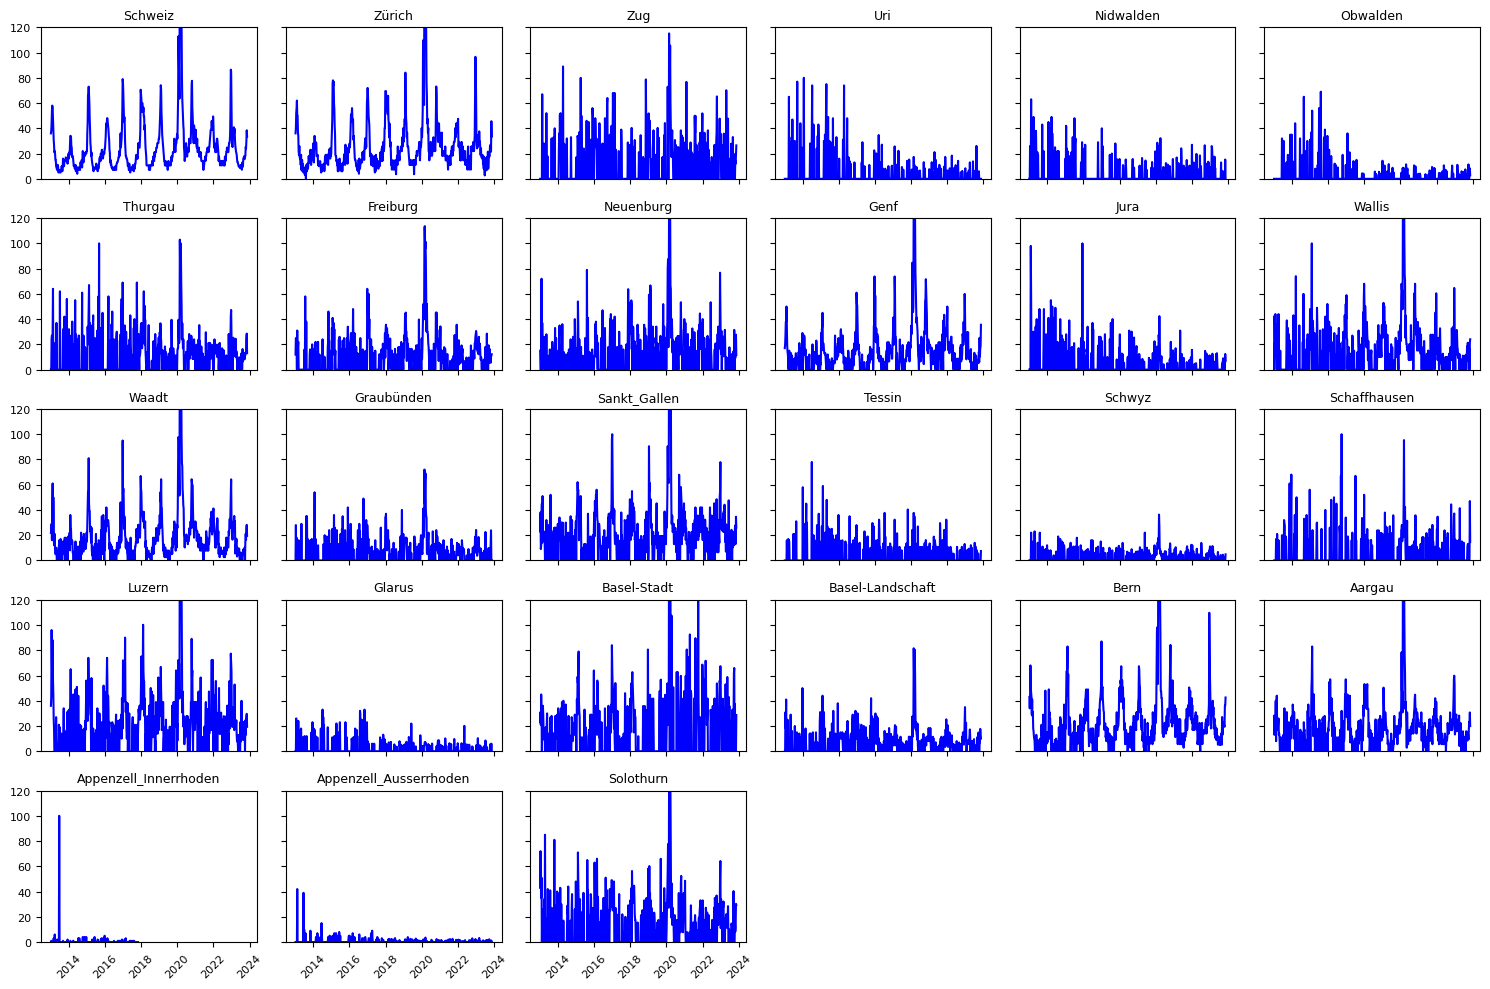

In [11]:
google_plot = google_trends_ch.copy()
google_plot.index = pd.to_datetime(google_plot.index)

# Plot each canton separately
fig, ax = plt.subplots(5, 6, figsize=(15, 10), sharex=True, sharey=True)

plt.style.use('ggplot')

# Adjust the subplots' layout
fig.subplots_adjust(hspace=0.5, wspace=0.5)

# Set a common y-axis limit
y_limit = 120

# Iterate through each subplot and plot the data
i, j = 0, 0
for canton in ['Schweiz', *cantons.keys()]:
    ax[i][j].plot(google_plot[canton, 'Grippe'], label=canton, color='blue')
    ax[i][j].set_title(canton, fontsize=9)
    ax[i][j].tick_params(axis='x', labelrotation=45)  # Rotate x-axis labels
    ax[i][j].tick_params(axis='both', labelsize=8)  # Set tick label size
    ax[i][j].set_ylim([0, y_limit])  # Set y-axis limit for each subplot
    
    # Move to next subplot
    if j == 5:
        i += 1
        j = 0
    else:
        j += 1

# Hide unused subplots
for p in range(i, 5):
    for q in range(j, 6):
        ax[p][q].axis('off')

# Adjust overall layout
plt.tight_layout()

plt.show()

In [12]:
# Import weekly population data per canton from Sentinella file
pop_ct = pd.read_csv("../data/INFLUENZA_oblig/data.csv")
pop_ct.head()
# Only keep aggregate observations at cantonal level 
pop_ct = pop_ct.query("sex == 'all' and type == 'all' and agegroup == 'all' and georegion_type == 'canton'")[['temporal', 'georegion', 'pop']]

pop_ct = pop_ct.pivot(index='temporal', columns='georegion', values='pop')
pop_ct.drop(columns='unknown', inplace=True)
pop_ct = pop_ct.T.reset_index().drop(columns='2012-W52')

pop_ct.rename(columns={'georegion': 'canton'}, inplace=True)
pop_ct['canton'] = list(map(lambda x: cantons_rev[x], pop_ct['canton']))
pop_ct = pop_ct.set_index('canton')


# Create dict for mapping of dates to index of calendar week for population mapping
week_dict = {}
for year in range(2013, 2024):
    weeks = list(filter(lambda x: x.startswith(f'{year}'), google_trends_ch.T.columns))

    week_dict.update({f'{week[:4]}-W{nr+1:02d}': week for nr, week in enumerate(weeks)})

pop_ct.rename(columns=week_dict, inplace=True)
pop_ct = pop_ct.T

In [19]:
import json
with open('week_dict.json', 'w') as f:
    json.dump(week_dict, f)

In [14]:
# Dictionary mapping regions to Cantons for aggregation of population
region_to_ct = {'Region_1': ['Genf', 'Neuenburg', 'Waadt', 'Wallis'], 
           'Region_2': ['Bern', 'Freiburg', 'Jura'], 
           'Region_3': ['Aargau', 'Basel-Landschaft', 'Basel-Stadt', 'Solothurn'], 
           'Region_4': ['Luzern', 'Nidwalden', 'Obwalden', 'Schwyz', 'Uri', 'Zug'], 
           'Region_5': ['Appenzell_Innerrhoden', 'Appenzell_Ausserrhoden', 'Glarus', 'Sankt_Gallen', 'Schaffhausen', 'Thurgau', 'Zürich'], 
           'Region_6': ['Graubünden', 'Tessin']}

# Insert columns for regional population numbers
for region in region_to_ct.keys():
    pop_ct[region] = pop_ct[[*region_to_ct[region]]].sum(axis=1)

# Dictionary mapping Cantons to regions for 
ct_to_reg = dict()
for key, value in region_to_ct.items():
    for ct in value:
        ct_to_reg[ct] = key

# Create new dataframe for weights as shares of regional population
ct_weights = pop_ct.copy()
for canton in cantons.keys():
    ct_weights[canton] = ct_weights[canton] / ct_weights[ct_to_reg[canton]]

In [15]:
# Add columns for weighted search activity by region
for level in google_trends_ch.columns.levels[1]:
    for region in region_to_ct.keys():
        # Initialize an empty DataFrame to store the weighted sums for each canton
        weighted_sums = pd.DataFrame()

        # Multiply the search activity for each canton by its weight and add to the DataFrame
        for canton in region_to_ct[region]:
            weighted_sums[canton] = google_trends_ch[canton, level] * ct_weights[canton]
        
        # Sum the weighted data for each canton to get the total for the region
        google_trends_ch[region, level] = weighted_sums.sum(axis=1)

Region_1: ['Genf', 'Neuenburg', 'Waadt', 'Wallis'], 
Region_2: ['Bern', 'Freiburg', 'Jura'], 
Region_3: ['Aargau', 'Basel-Landschaft', 'Basel-Stadt', 'Solothurn'], 
Region_4: ['Luzern', 'Nidwalden', 'Obwalden', 'Schwyz', 'Uri', 'Zug'], 
Region_5: ['Appenzell_Innerrhoden', 'Appenzell_Ausserrhoden', 'Glarus', 'Sankt_Gallen', 'Schaffhausen', 'Thurgau', 'Zürich'], 
Region_6: ['Graubünden', 'Tessin']


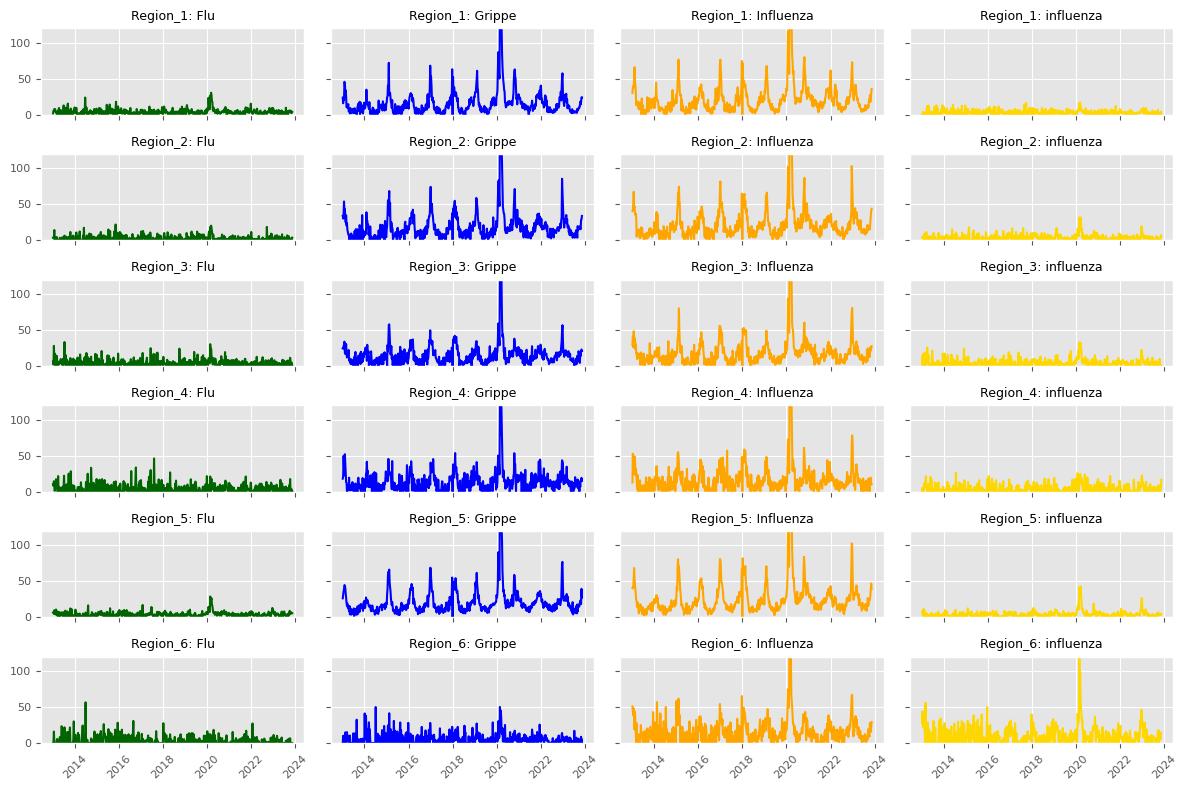

In [16]:
google_plot = google_trends_ch.copy()
google_plot.index = pd.to_datetime(google_plot.index)

# Plot regional
fig, ax = plt.subplots(6, 4, figsize=(12, 8), sharex=True, sharey=True)

# Set a common y-axis limit
y_limit = 120

# Initialize a dictionary to map queries to colors
color_dict = {'Grippe':'blue', 'Influenza':'orange', 'influenza':'gold', 'Flu':'darkgreen'}

i, j = 0, 0
for region in region_to_ct.keys():
    for query in google_plot.columns.levels[1]:
        ax[i][j].plot(google_plot[region, query], color=color_dict[query])
        ax[i][j].set_title(f'{region}: {query}', fontsize=9)
        ax[i][j].tick_params(axis='x', labelrotation=45)  # Rotate x-axis labels
        ax[i][j].tick_params(axis='both', labelsize=8)  # Set tick label size
        ax[i][j].set_ylim([0, y_limit])  # Set y-axis limit for each subplot

        j += 1
    j = 0
    i += 1

title_parts = [f'{region}: {region_to_ct[region]}' for region in region_to_ct.keys()]

# Joining the title parts with a comma and a space
title_string = ', \n'.join(title_parts)

print(title_string)

# Adjust overall layout
plt.tight_layout()

plt.show()

<h3>Decomposition of countrywide search activity for "Grippe" in Switzerland</h3>

In [17]:
# Prepping data for decomposition
zh = google_trends_ch[[('Zürich', 'Grippe')]]
zh = zh.reset_index()
zh['Woche'] = pd.to_datetime(zh['Woche'])
zh = zh.set_index('Woche')

zh = zh[('Zürich', 'Grippe')]

zh = zh.asfreq('W-SUN')

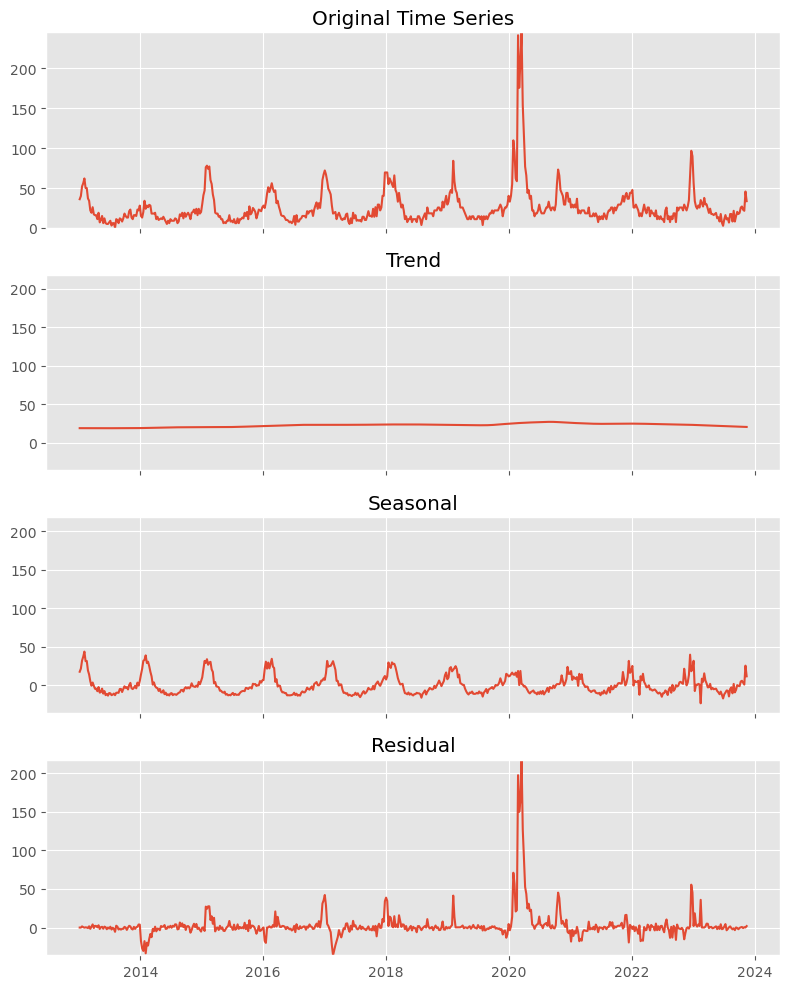

In [18]:
# Apply STL decomposition
res = STL(zh, period=52, robust=True).fit()  # 'period=52' for weekly data

# Plot the results
fig, axs = plt.subplots(4, sharex=True, figsize=(8, 10))  # Increase the number of subplots to 4

# Determine the common y-axis range for the components (excluding the original time series for clarity)
common_ylim = (min(res.trend.min(), res.seasonal.min(), res.resid.min()),
               max(res.trend.max(), res.seasonal.max(), res.resid.max()))

# Plot the original time series
axs[0].plot(zh, label='Original')
axs[0].set_title('Original Time Series')
# Optionally, you can set the y-axis limit for the original time series to its own min and max
axs[0].set_ylim(zh.min(), zh.max())

# Plot each decomposed component with the same y-axis limits
axs[1].plot(res.trend)
axs[1].set_title('Trend')
axs[1].set_ylim(common_ylim)

axs[2].plot(res.seasonal)
axs[2].set_title('Seasonal')
axs[2].set_ylim(common_ylim)

axs[3].plot(res.resid)
axs[3].set_title('Residual')
axs[3].set_ylim(common_ylim)

# Show the plot with a tight layout
plt.tight_layout()
plt.show()

<h3>Flu data</h3>
<ul>
    <li>Region 1: GE, NE, VD, VS</li> 
    <li>Region 2: BE, FR, JU </li>
    <li>Region 3: AG, BL, BS, SO </li>
    <li>Region 4: LU, NW, OW, SZ, UR, ZG</li> 
    <li>Region 5: AI, AR, GL, SG, SH, TG, ZH </li>
    <li>Region 6: GR, TI</li>
</ul> 